In [1]:
###归一化、无数据增强功能###
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Set random seed for PyTorch and NumPy
# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data, and store the transformation matrix ps_in
p_scaled = scaler_in.fit_transform(input)
p = torch.FloatTensor(p_scaled.T)
ps_in = scaler_in.scale_

# Fit and transform EAB data, and store the transformation matrix ts_out
t_scaled = scaler_out.fit_transform(EAB.reshape(-1, 1))
t = torch.FloatTensor(t_scaled)
ts_out = scaler_out.scale_

print("Scaled Data Shapes:")
print(p_scaled.shape)
print(t_scaled.shape)

# Define the ratio for training and testing data
train_ratio = 0.80  # 80% training data
test_ratio = 0.20   # 20% testing data

# Set the desired dataset size
dataset_size = 2000  # Adjust as needed, but it should be <= len(EAB)

# Number of samples
n_samples = min(len(EAB), dataset_size)

# Create a random permutation of indices for shuffling
indices = np.random.permutation(n_samples)

# Calculate the sizes of the training and test sets
n_train = int(train_ratio * n_samples)
n_test = n_samples - n_train

# Use the shuffled indices to split the data into training and test sets
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data into training and test sets based on the shuffled indices
X_train, y_train = p_scaled[train_indices], t_scaled[train_indices]
X_test, y_test = p_scaled[test_indices], t_scaled[test_indices]

print("Training Data Shapes:")
print(X_train.shape, y_train.shape)
print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# Print the actual dataset size used for training and testing
print(f"Actual Dataset Size: {n_samples}")

# Print the first 5 rows of training and test data
print("First 5 rows of Training Data:")
print(X_train[:5])
print("First 5 rows of Training Target (y_train):")
print(y_train[:5])

print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

print("First 5 rows of Test Data:")
print(X_test[:5])
print("First 5 rows of Test Target (y_test):")
print(y_test[:5])

Scaled Data Shapes:
(2000, 10)
(2000, 1)
Training Data Shapes:
(1600, 10) (1600, 1)
Test Data Shapes:
(400, 10) (400, 1)
Actual Dataset Size: 2000
First 5 rows of Training Data:
[[-0.25965113 -0.28182957 -0.34621546 -0.464       0.44001823 -0.27145981
   0.41572625 -0.46539162 -0.41602914 -0.15544843]
 [ 0.37231913 -0.41666667  0.025831   -0.2285     -0.08851413  0.0744487
   0.17983254 -0.43151184  0.33023679 -0.40722212]
 [ 0.34315127  0.45137845 -0.00901081  0.497      -0.04658159  0.0655185
  -0.44867128  0.33351548 -0.35318761  0.06612698]
 [-0.20088647  0.04699248  0.08229876  0.241      -0.32023701 -0.03435393
  -0.27302512 -0.19398907  0.33424408  0.36538112]
 [-0.21089505 -0.0726817   0.335002    0.465       0.07010027 -0.41306725
  -0.43756826 -0.01693989  0.38615665 -0.43469165]]
First 5 rows of Training Target (y_train):
[[-0.51131868]
 [ 0.07615385]
 [ 0.01087912]
 [-0.11967033]
 [-0.18494505]]
Test Data Shapes:
(400, 10) (400, 1)
First 5 rows of Test Data:
[[-0.0175865   

Training duration: 0.36 seconds


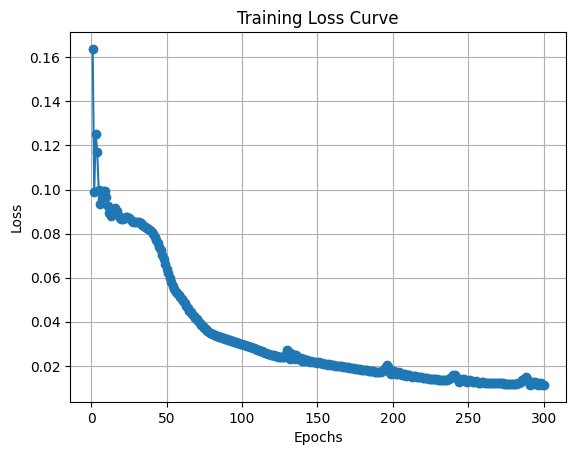

R-squared (r_train) on training set: 0.884
Mean Absolute Error (MAE) on training set: 0.086
Mean Squared Error (MSE) on training set: 0.012
Root Mean Squared Error (RMSE) on training set: 0.108
R-squared (r_test) on test set: 0.819
Mean Absolute Error (MAE) on test set: 0.102
Mean Squared Error (MSE) on test set: 0.017
Root Mean Squared Error (RMSE) on test set: 0.131
correlation_train: 0.943
correlation_test: 0.908


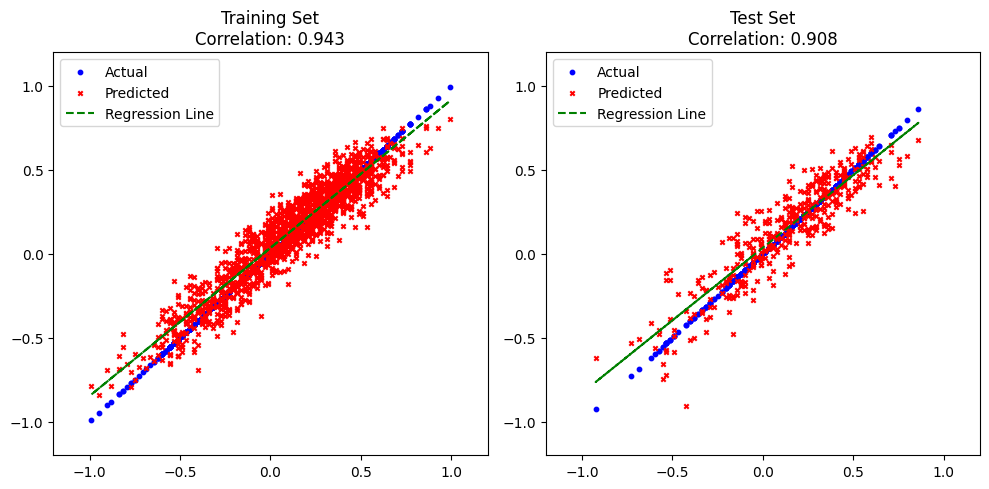

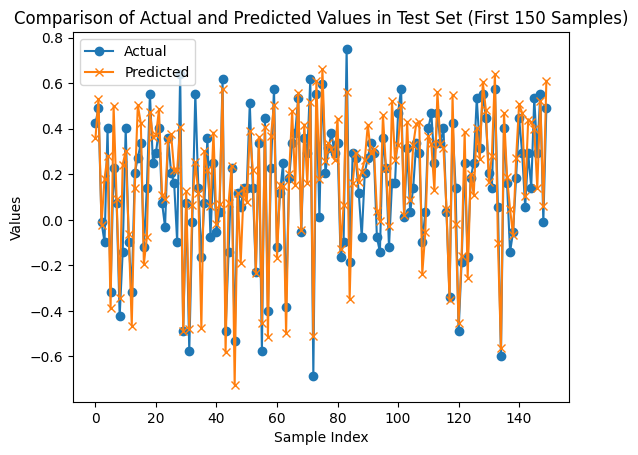

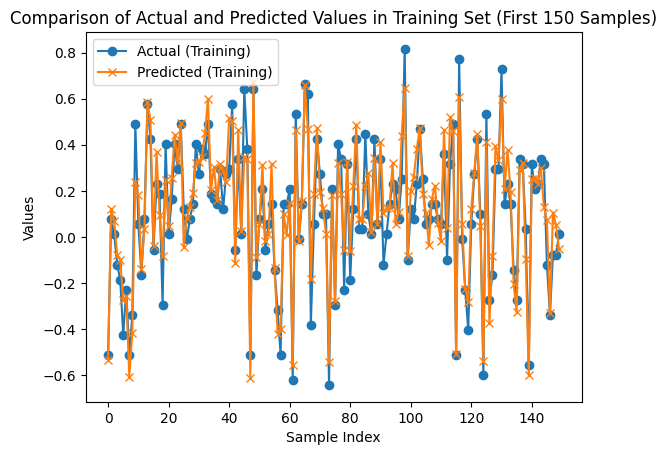

In [2]:
####无网格搜索功能、无Dropout技术####
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import time

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):      #无初始化功能
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())  #双曲正切
                #self.layers.append(nn.ReLU())   #ReLU
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

kk1 = 14   # Neuron number in 1st hidden layer 14
kk2 = 12  # Neuron nu#mber in 2nd hidden layer12
kk3 = 8  # Neuron number in 3rd hidden layer8
kk4 = 3  # Neuron number in 4th hidden layer  3
#kk5 = 4  # Neuron number in 4th hidden layer 
# Hyperparameters
input_dim = 10  # Input dimension (adjust as needed)
output_dim = 1  # Output dimension
hidden_dims = [kk1, kk2, kk3, kk4]  # , kk4, kk5 Hidden layer dimensions (adjust as needed)
learning_rate = 0.02  # Learning rate
max_epochs = 300  # Maximum epochs (adjust as needed)

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)

# Define the optimizer and loss function
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train)
targets = torch.FloatTensor(y_train)

# Record the start time
start_time = time.time()

losses = []
# Train the DNN
for epoch in range(max_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = dnn(inputs)
    
    # Calculate the loss
    loss = criterion(outputs, targets)
    losses.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}")
        
# Record the end time
end_time = time.time()
# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration:.2f} seconds")

# 绘制损失曲线
plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()  

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
with torch.no_grad():
    predicted_train = dnn(torch.FloatTensor(X_train))
    train_true_values = y_train
    r_train = r2_score(train_true_values, predicted_train)
    mae_train = mean_absolute_error(train_true_values, predicted_train)   # MAE training set
    mse_train = mean_squared_error(train_true_values, predicted_train)    # MSE training set
    rmse_train = math.sqrt(mse_train)                               # RMSE training set

print(f"R-squared (r_train) on training set: {r_train:.3f}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train:.3f}")
print(f"Mean Squared Error (MSE) on training set: {mse_train:.3f}")
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train:.3f}")

with torch.no_grad():              # Perform regression analysis on the test set (X_test, y_test)
    predicted_test = dnn(torch.FloatTensor(X_test))
    test_true_values = y_test
    r_test = r2_score(test_true_values, predicted_test)
    mae_test = mean_absolute_error(test_true_values, predicted_test)   #MAE test set
    mse_test = mean_squared_error(test_true_values, predicted_test)    # MSE test set
    rmse_test = math.sqrt(mse_test)                               #RMSE test set
    predicted_train = dnn(torch.FloatTensor(X_train))

print(f"R-squared (r_test) on test set: {r_test:.3f}")
print(f"Mean Absolute Error (MAE) on test set: {mae_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.3f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.3f}")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
print(f"correlation_train: {correlation_train:.3f}")

axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
regression_train = LinearRegression()
regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
print(f"correlation_test: {correlation_test:.3f}")
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
regression_test = LinearRegression()
regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
num_samples_to_plot = 150  # Set the number of samples you want to plot

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples
plt.plot(actual_test[:num_samples_to_plot], label='Actual', marker='o')
plt.plot(predicted_test[:num_samples_to_plot], label='Predicted', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Test Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples in the training set
plt.plot(actual_train[:num_samples_to_plot], label='Actual (Training)', marker='o')
plt.plot(predicted_train[:num_samples_to_plot], label='Predicted (Training)', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Training Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()